In [1]:
#WEB TRAFFIC PREDICTION USING TIME SERIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot, autocorrelation_plot
import statsmodels.api as sm
from scipy import stats


In [2]:
df=pd.read_csv("/content/website_wata trial2.csv")

DATA OVERVIEW

In [3]:
df.head()

,Page Views,Session Duration,Bounce Rate,Traffic Source,Time on Page,Previous Visits,Conversion Rate
0,5,11.051381,0.230652,Organic,3.890460,3,1.0
1,4,3.429316,0.391001,Social,8.478174,0,1.0
2,4,1.621052,0.397986,Organic,9.636170,2,1.0
3,5,3.629279,0.180458,Organic,2.071925,3,1.0
4,5,4.235843,0.291541,Paid,1.960654,5,1.0


Page views accounts to the number of pages viewed during a session(user engagement).
Session duration -time spent by a user on the website.
Bounce Rate -numerical measuring the proportion of sessions a user left the site after visiting only one page.
Traffic source-origin of traffic.
Time on page- average time user spend on page.
Previous visits-count of how many times the user visited the site previously.
Conversion rate- proportion of sessions that resulted in a predefined action.

In [4]:
df.shape

(2000, 7)

In [5]:
df.size

14000

In [6]:
#check datatypes and null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Page Views        2000 non-null   int64  
 1   Session Duration  2000 non-null   float64
 2   Bounce Rate       2000 non-null   float64
 3   Traffic Source    2000 non-null   object 
 4   Time on Page      2000 non-null   float64
 5   Previous Visits   2000 non-null   int64  
 6   Conversion Rate   2000 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 109.5+ KB


In [7]:
#undserstand summary stats
df.describe(include='all')


,Page Views,Session Duration,Bounce Rate,Traffic Source,Time on Page,Previous Visits,Conversion Rate
count,2000.000000,2000.000000,2000.000000,2000,2000.000000,2000.000000,2000.000000
unique,NaN,NaN,NaN,5,NaN,NaN,NaN
top,NaN,NaN,NaN,Organic,NaN,NaN,NaN
freq,NaN,NaN,NaN,786,NaN,NaN,NaN
mean,4.950500,3.022045,0.284767,NaN,4.027439,1.978500,0.982065
std,2.183903,3.104518,0.159781,NaN,2.887422,1.432852,0.065680
min,0.000000,0.003613,0.007868,NaN,0.068515,0.000000,0.343665
25%,3.000000,0.815828,0.161986,NaN,1.935037,1.000000,1.000000
50%,5.000000,1.993983,0.266375,NaN,3.315316,2.000000,1.000000
75%,6.000000,4.197569,0.388551,NaN,5.414627,3.000000,1.000000


Page views accounts to the number of pages viewed during a session(user engagement).
Session duration -time spent by a user on the website.
Bounce Rate -numerical measuring the proportion of sessions a user left the site after visiting only one page.
Traffic source-origin of traffic.

In [8]:
#checking null values
df.isnull().sum()

,0
Page Views,0
Session Duration,0
Bounce Rate,0
Traffic Source,0
Time on Page,0
Previous Visits,0
Conversion Rate,0


In [9]:
numerical_cols = df.select_dtypes(include=np.number).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

In [10]:
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

In [11]:
#duplicates
f"Duplicates: {df.duplicated().sum()}"

'Duplicates: 0'

In [12]:
df = df.drop_duplicates()

UNIVARIATE ANALYSIS
numerical features

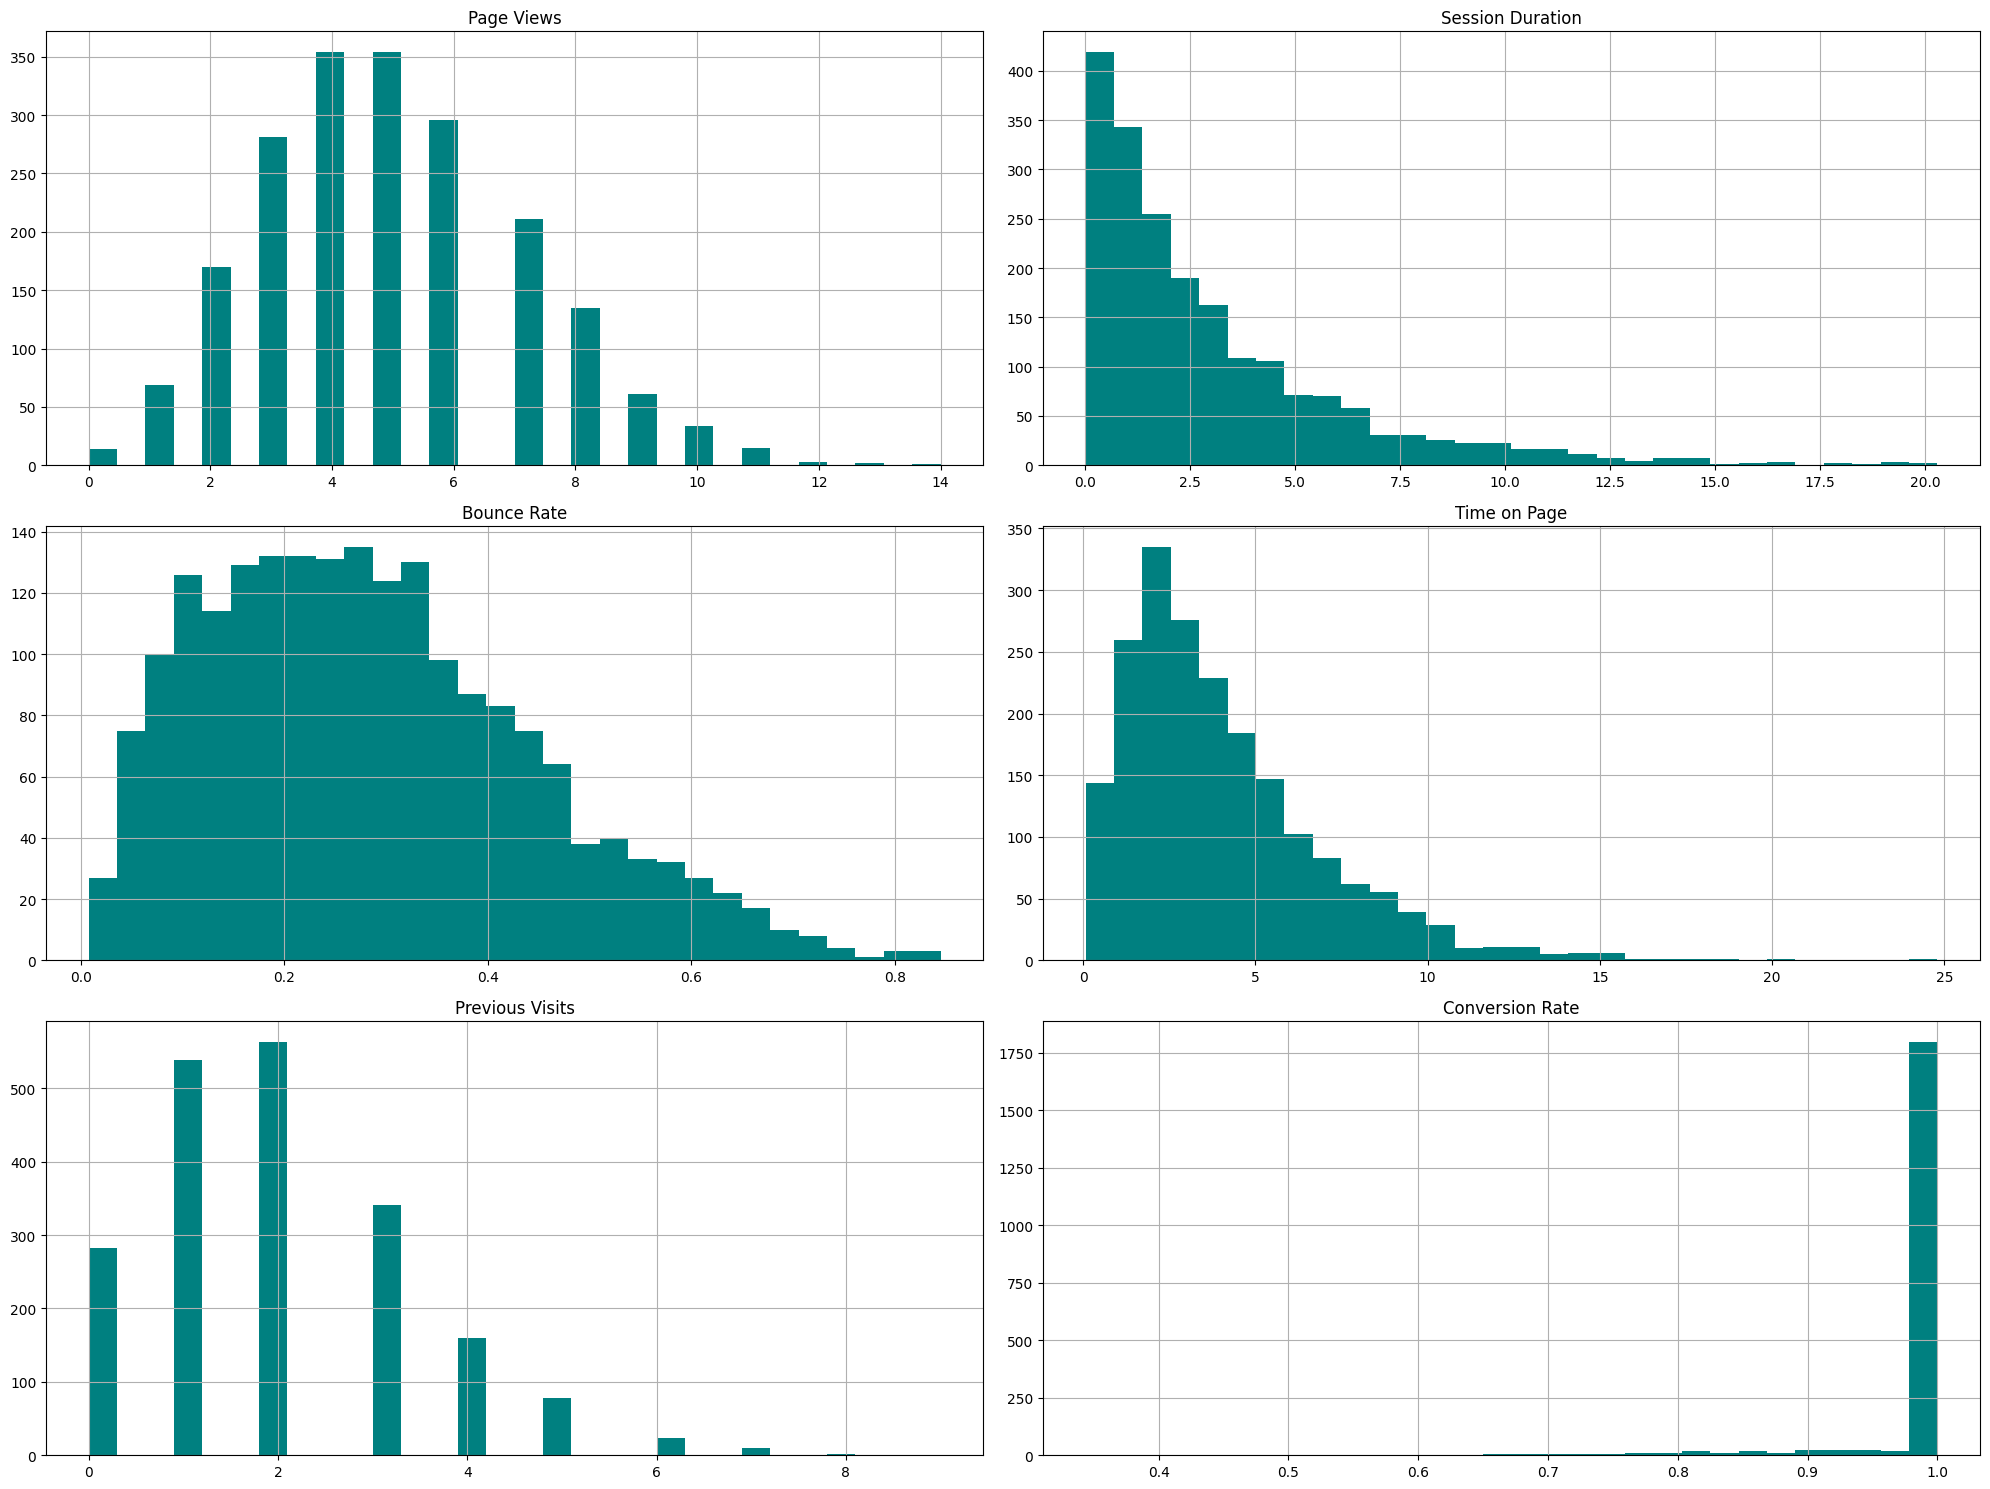

In [13]:
#histograms
df.hist(bins=30, figsize=(20, 15), color='teal')
plt.tight_layout()
plt.show()

1. Page views-indicate a pick between 4 and 5 showing that users most commonly explore 4–5 pages before leaving the website.(shows the distribution of page views across all sessions.)
2. Session duration-right skewed meaning most users spend very little time, with a few spending significantly more time.
3. Bounce rate-High bounce rate values (>0.5) suggest users often leave the site after minimal interaction, potentially due to irrelevant content or poor navigation while a low bounce rate (around 0.1–0.2) suggests higher engagement, where users tend to explore beyond the landing page.
4. Time on page-peak between 2-5 which may provide insights on how users consume content.
5. Previous visits-indicates there is a mix of first timers and repeat visitors on the website.
6. Conversion rate-indicate strong user intent.

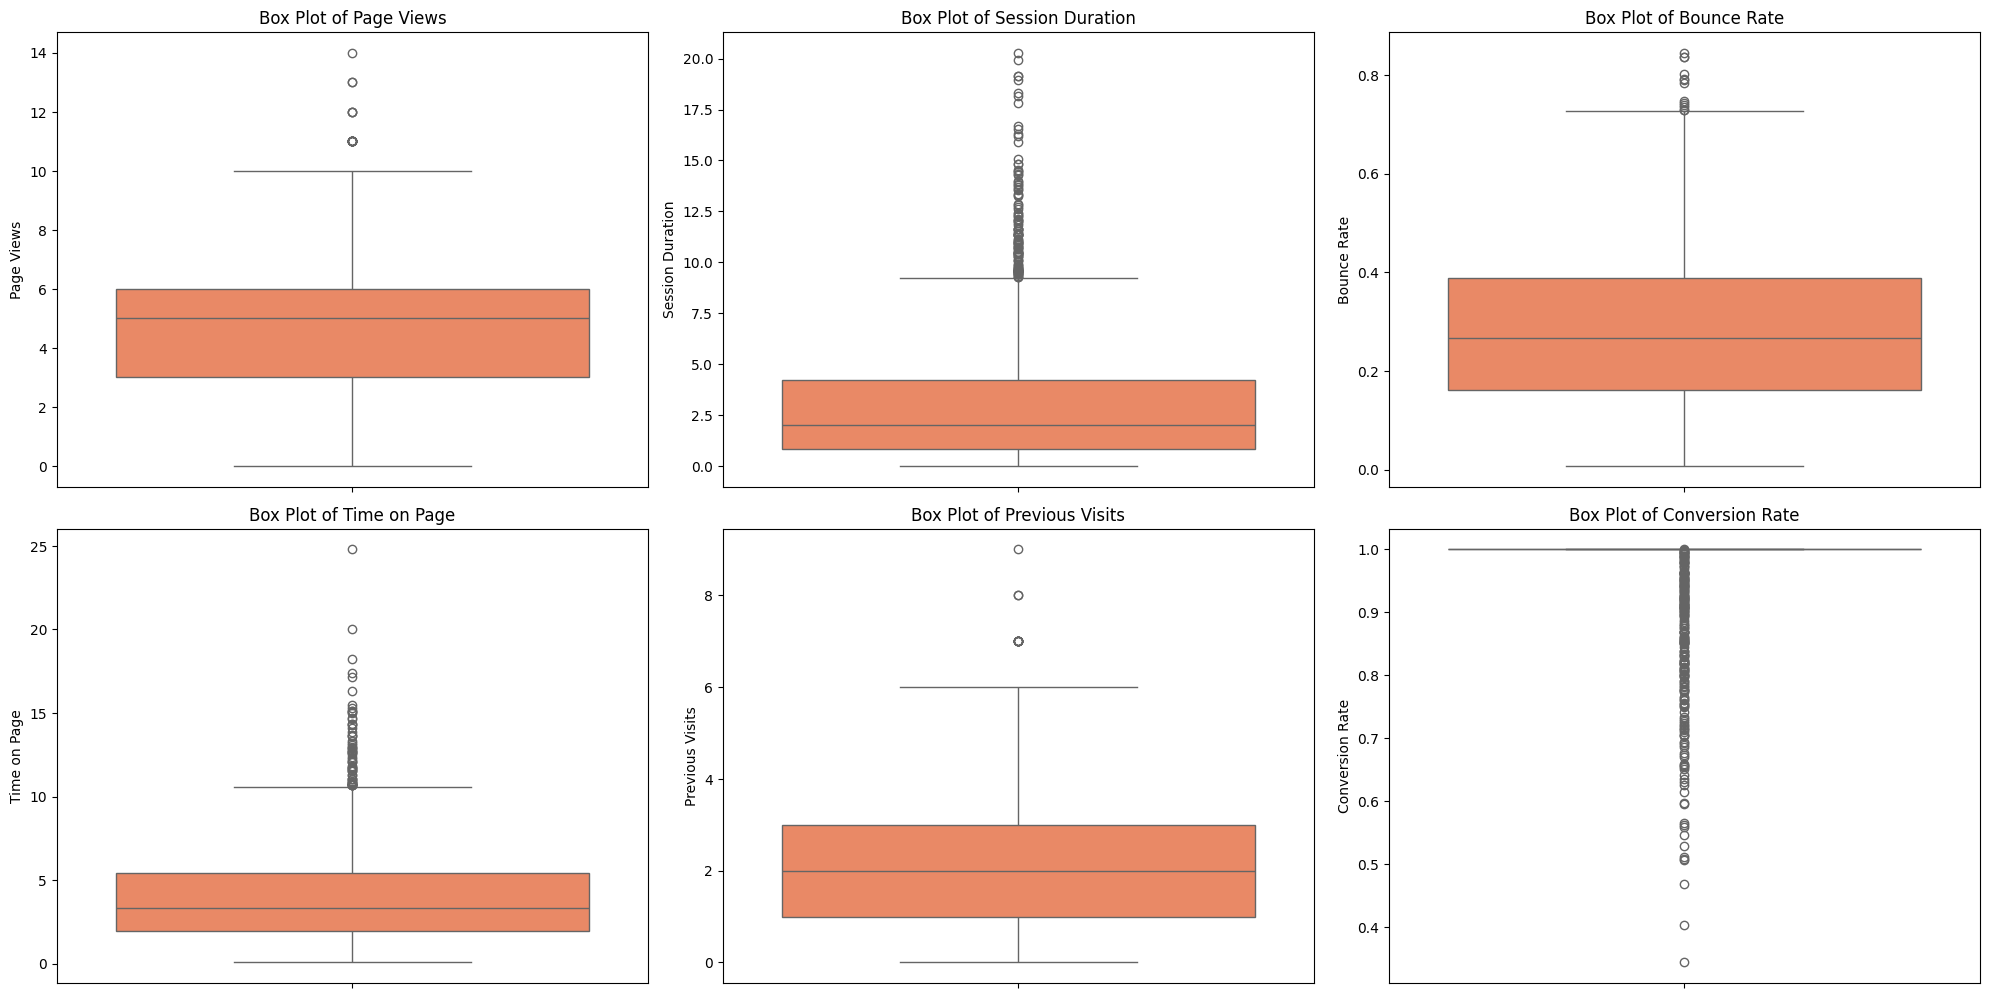

In [14]:
#box plots
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col], color='coral')
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()


Categorical features

In [15]:
#value counts
for col in categorical_cols:
    print(f"\nValue counts for {col}:\n{df[col].value_counts()}")


Value counts for Traffic Source:
Traffic Source
Organic     786
Paid        428
Referral    301
Social      269
Direct      216
Name: count, dtype: int64


<ipython-input-16-4e253399ea3f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')


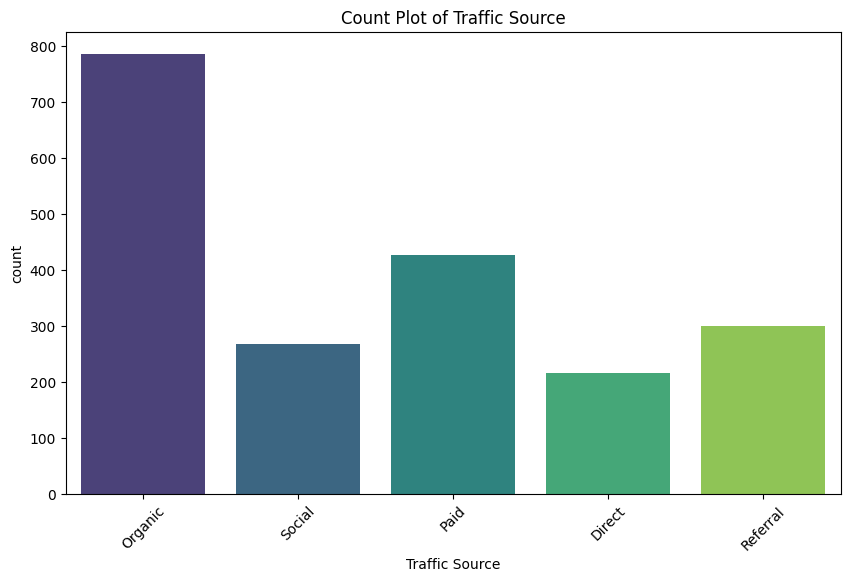

In [16]:
#bar plots
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, palette='viridis')
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)
    plt.show()

Organic has the highest bar indicating that most traffic comes from search engines.
Paid is the second suggesting that paid marketing campaigns are bringing a significant traffic.


BIVARIATE ANALYSIS

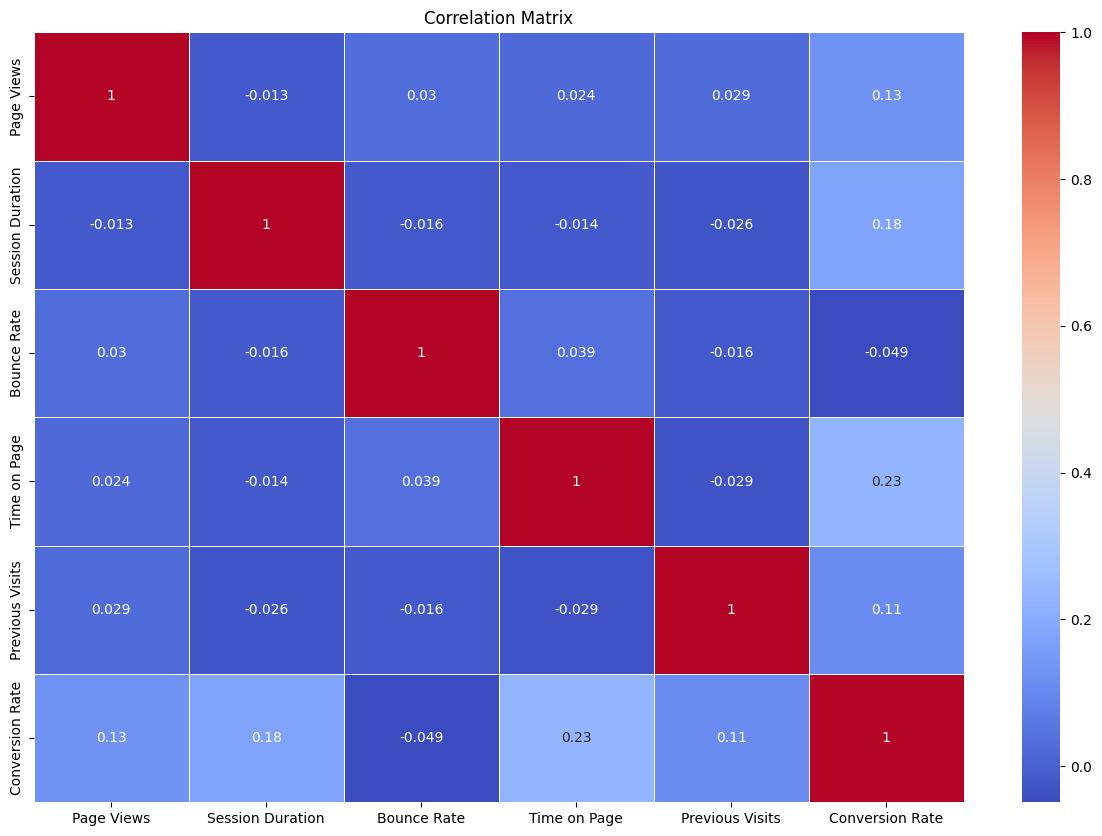

In [17]:
#correlation matrix
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

when the correlation is high or close to 1 means that as one variable increases the other also increases.
when its low or close to -1 means as one variable increases the other descreases.
Page views and convesion rate have high correlation indicating that users who view more pages are more likely to perform the desired action. It suggests that user engagement is a key driver of conversions.

categorical vs numerical

<ipython-input-18-1242aa63ab76>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='Set2')


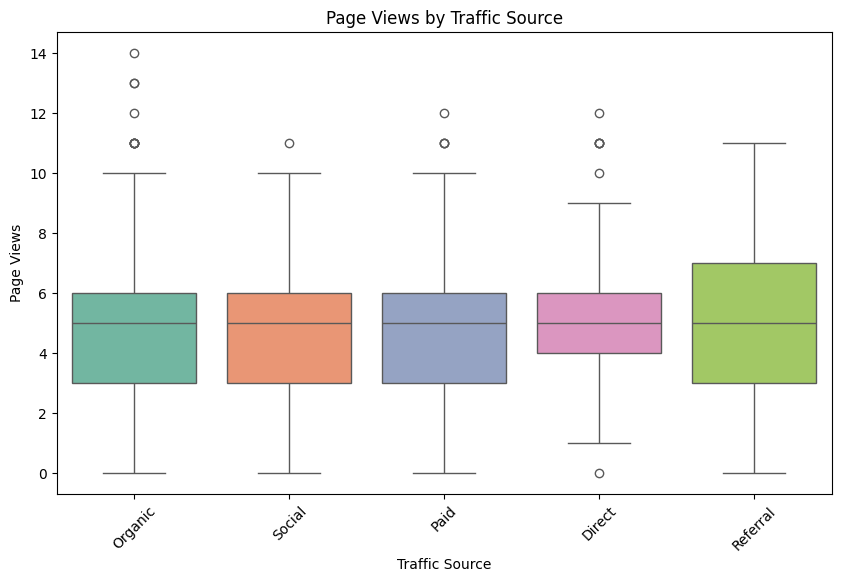

<ipython-input-18-1242aa63ab76>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='Set2')


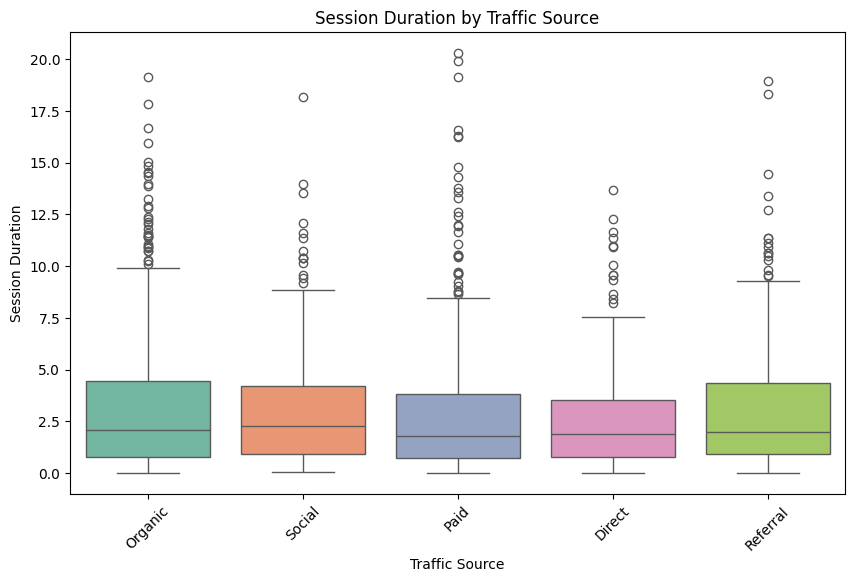

<ipython-input-18-1242aa63ab76>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='Set2')


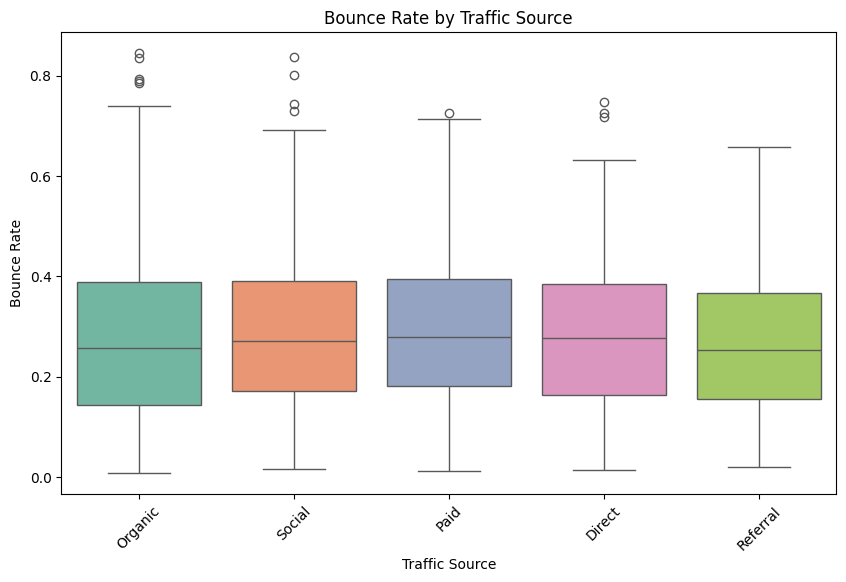

<ipython-input-18-1242aa63ab76>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='Set2')


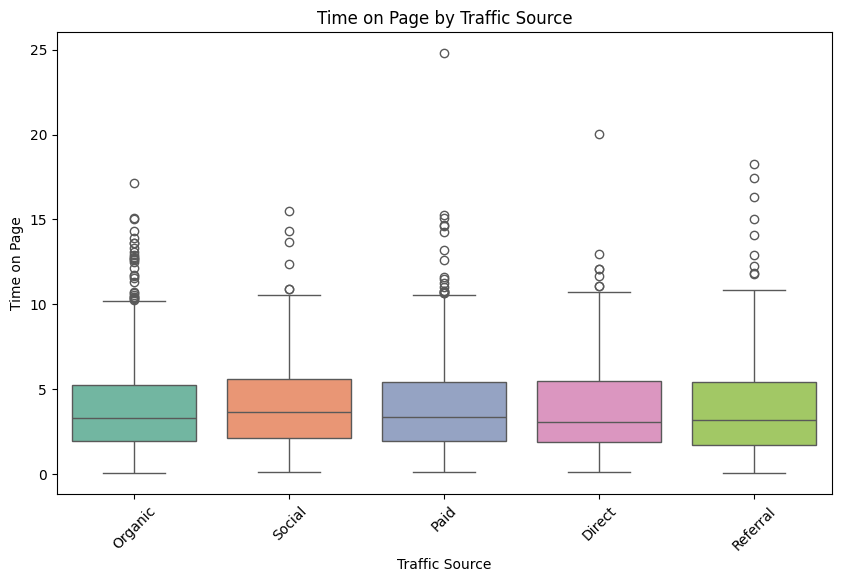

<ipython-input-18-1242aa63ab76>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='Set2')


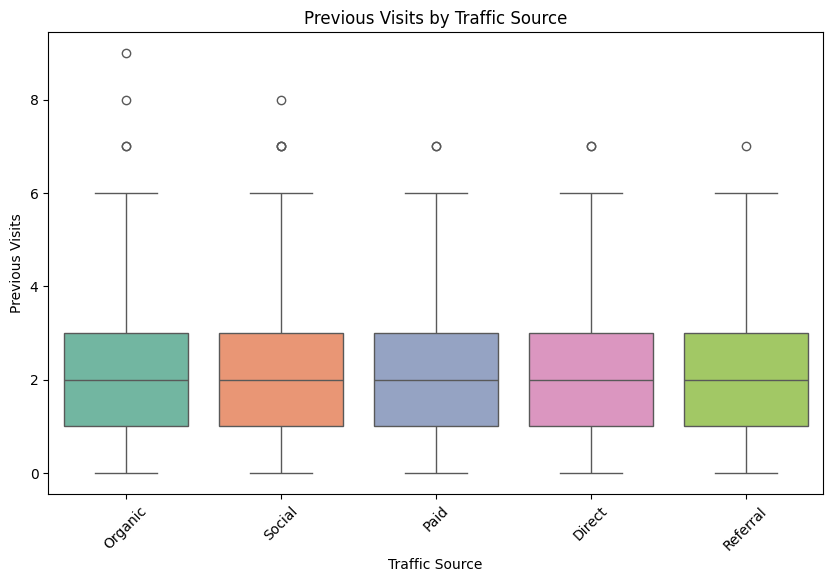

<ipython-input-18-1242aa63ab76>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='Set2')


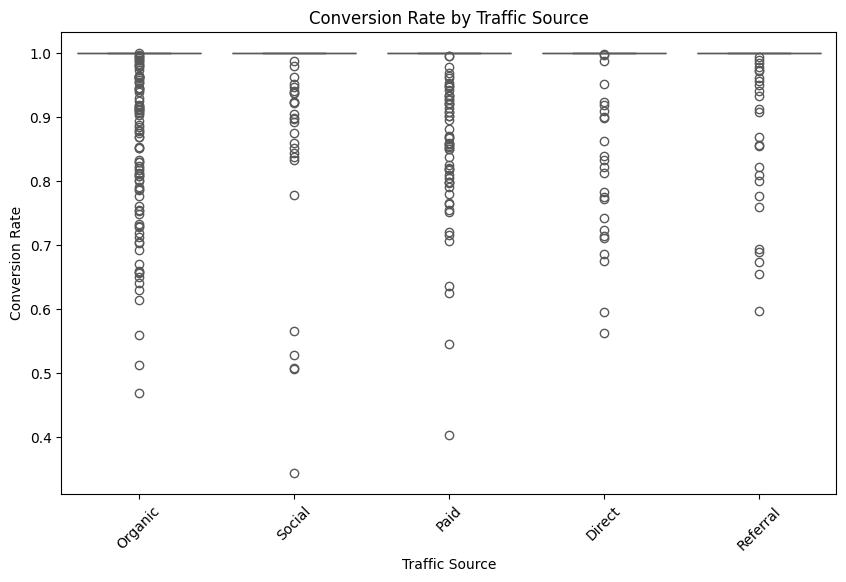

In [18]:
#box plots
for cat_col in categorical_cols:
    for num_col in numerical_cols:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x=cat_col, y=num_col, palette='Set2')
        plt.title(f'{num_col} by {cat_col}')
        plt.xticks(rotation=45)
        plt.show()


TIME SERIES ANALYSIS

In [19]:
df.columns

Index(['Page Views', 'Session Duration', 'Bounce Rate', 'Traffic Source',
       'Time on Page', 'Previous Visits', 'Conversion Rate'],
      dtype='object')

In [20]:
# Create a date range starting from a specific date
df['Date'] = pd.date_range(start='2023-01-01', periods=len(df), freq='D')

# Set 'Date' as the index
df.set_index('Date', inplace=True)

#DataFrame with the new Date index
print(df)

            Page Views  Session Duration  Bounce Rate Traffic Source  \
Date                                                                   
2023-01-01           5         11.051381     0.230652        Organic   
2023-01-02           4          3.429316     0.391001         Social   
2023-01-03           4          1.621052     0.397986        Organic   
2023-01-04           5          3.629279     0.180458        Organic   
2023-01-05           5          4.235843     0.291541           Paid   
...                ...               ...          ...            ...   
2028-06-18           1          2.724513     0.207187       Referral   
2028-06-19           3          0.392856     0.095559        Organic   
2028-06-20           4          9.899823     0.446622        Organic   
2028-06-21           3          0.393319     0.278340           Paid   
2028-06-22           3          0.882638     0.338026         Direct   

            Time on Page  Previous Visits  Conversion Rate  
Da

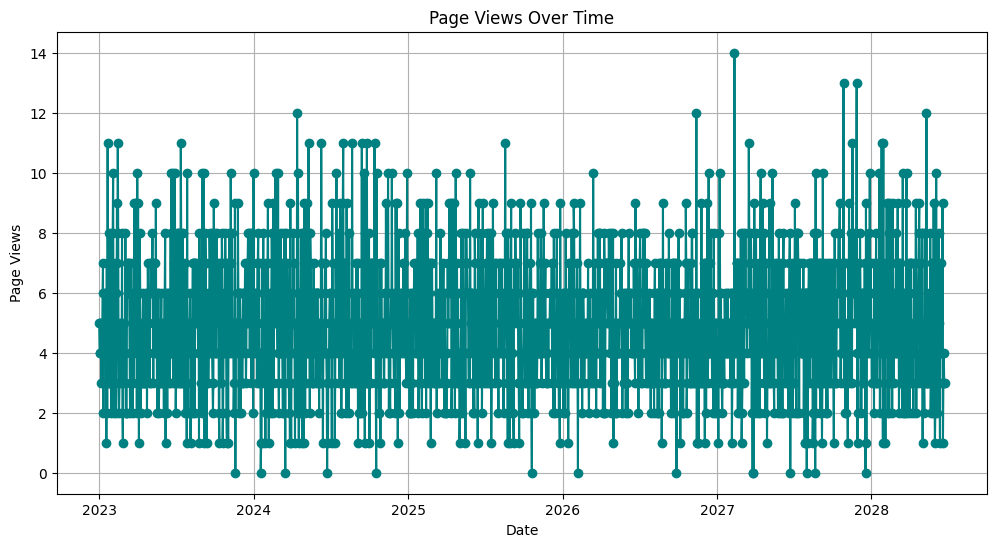

In [21]:
#time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Page Views'], marker='o', linestyle='-', color='teal')
plt.title('Page Views Over Time')
plt.xlabel('Date')
plt.ylabel('Page Views')
plt.grid(True)
plt.show()

highest and lowest number of page views occurred in 2027.

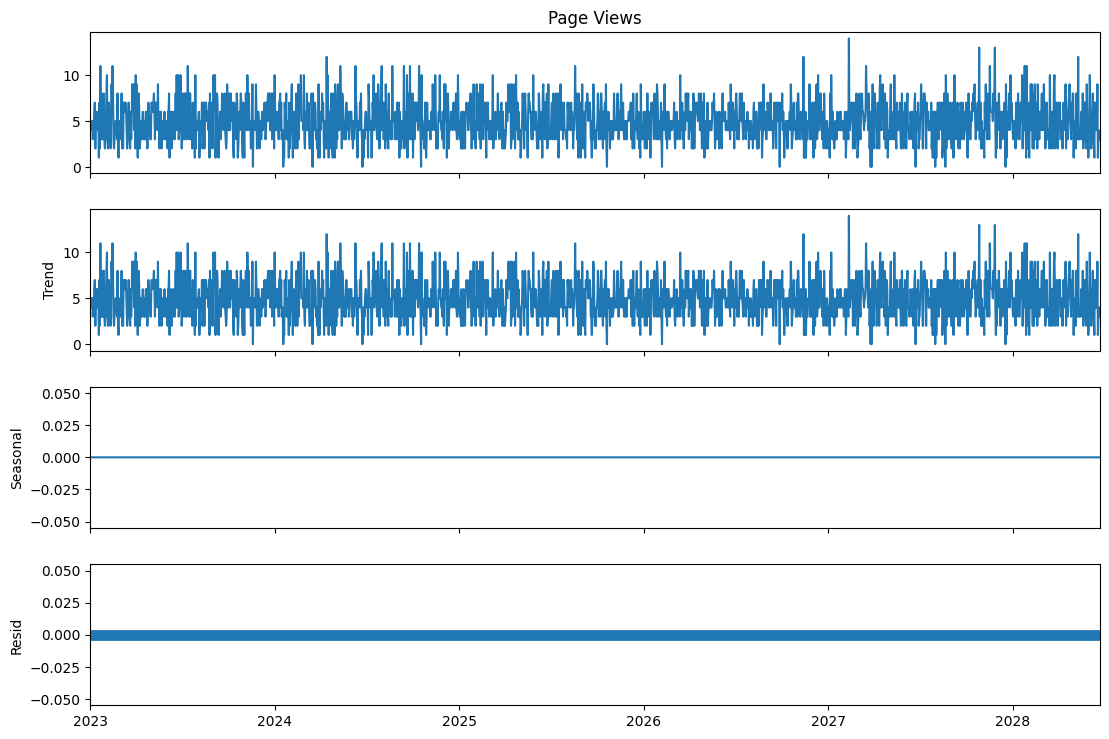

In [22]:
#decomposition
# Since we have limited data, we'll specify a period (seasonal cycle length)
# Let's assume a daily pattern repeats every 1 day (not very meaningful with 5 points)

decomposition = sm.tsa.seasonal_decompose(df['Page Views'], model='additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()


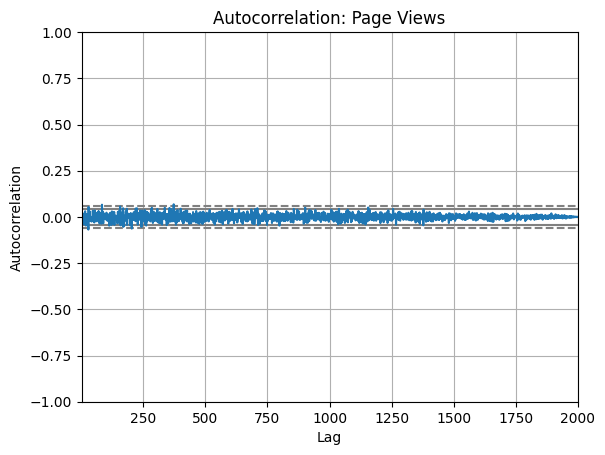

In [23]:
#autocorrelation plot
autocorrelation_plot(df['Page Views'])
plt.title('Autocorrelation: Page Views')
plt.show()

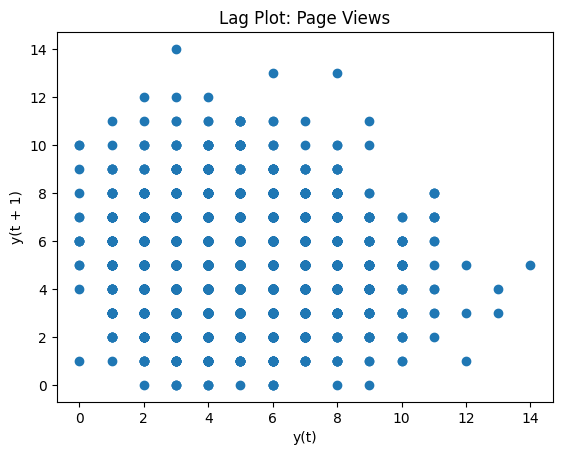

In [24]:
#lag plot
lag_plot(df['Page Views'])
plt.title('Lag Plot: Page Views')
plt.show()


In [25]:
#outlier detection
from scipy.stats import zscore

# Get numerical columns currently in the DataFrame (excluding the index)
df_numeric = df.select_dtypes(include=np.number)

z_scores = np.abs(zscore(df_numeric))

outliers = df[(z_scores > 3).any(axis=1)]

print(f'Number of Outliers: {outliers.shape[0]}')


Number of Outliers: 151


In [26]:
#handling
df_clean = df[(z_scores < 3).all(axis=1)]


FEATURE ENGINEERING

In [27]:
#log transformation
df['Log_Page_Views'] = np.log1p(df['Page Views'])

In [28]:
#binnig
df['Session_Duration_Bin'] = pd.qcut(df['Session Duration'], q=4, labels=False)


MULTIVARIATE ANALYSIS(btw 3 variables)

In [29]:
#Multicollinearity Check
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[numerical_cols].dropna()
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)



            feature        VIF
0        Page Views   6.258130
1  Session Duration   1.997322
2       Bounce Rate   4.085849
3      Time on Page   3.067566
4   Previous Visits   2.957460
5   Conversion Rate  14.664666


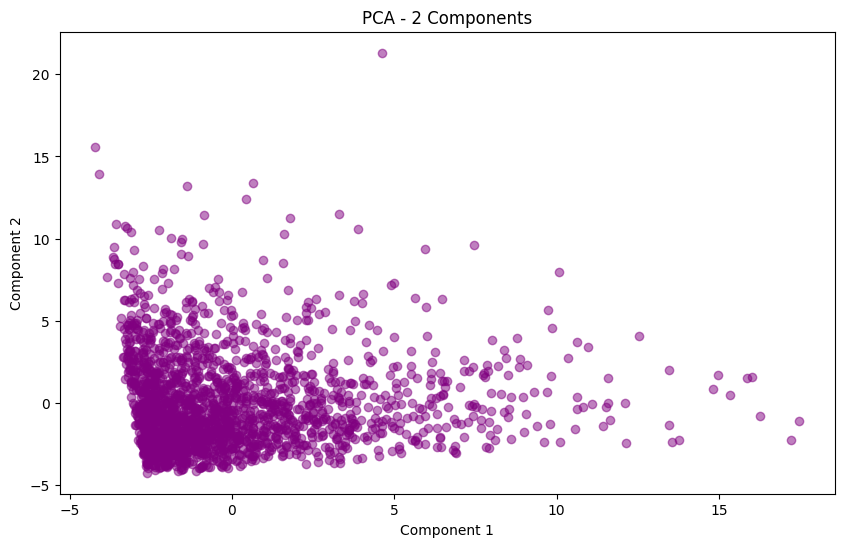

In [30]:
#pca-reduce dimensionality
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(df_numeric)

plt.figure(figsize=(10, 6))
plt.scatter(components[:, 0], components[:, 1], c='purple', alpha=0.5)
plt.title('PCA - 2 Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


HYPOTHESIS TESTING

In [31]:
#anova
from scipy.stats import f_oneway

for num_col in numerical_cols:
    groups = [df[df[cat_col]==category][num_col] for category in df[cat_col].unique()]
    f_stat, p_value = f_oneway(*groups)
    print(f"ANOVA for {num_col} by {cat_col}: p-value = {p_value}")


ANOVA for Page Views by Traffic Source: p-value = 0.32169847271758695
ANOVA for Session Duration by Traffic Source: p-value = 0.4574705511880943
ANOVA for Bounce Rate by Traffic Source: p-value = 0.09886476816525581
ANOVA for Time on Page by Traffic Source: p-value = 0.8318234334114719
ANOVA for Previous Visits by Traffic Source: p-value = 0.3302810651978982
ANOVA for Conversion Rate by Traffic Source: p-value = 0.4383216449011308


There is no significant difference btw groups in time on page and bounce rate. The rest show significant change btw groups.

In [32]:
#correlation significance
for col in numerical_cols:
    corr, p_value = stats.pearsonr(df['Page Views'], df[col])
    print(f"Correlation between Page Views and {col}: {corr:.4f}, p-value = {p_value:.4f}")


Correlation between Page Views and Page Views: 1.0000, p-value = 0.0000
Correlation between Page Views and Session Duration: -0.0128, p-value = 0.5676
Correlation between Page Views and Bounce Rate: 0.0302, p-value = 0.1767
Correlation between Page Views and Time on Page: 0.0239, p-value = 0.2845
Correlation between Page Views and Previous Visits: 0.0286, p-value = 0.2012
Correlation between Page Views and Conversion Rate: 0.1266, p-value = 0.0000


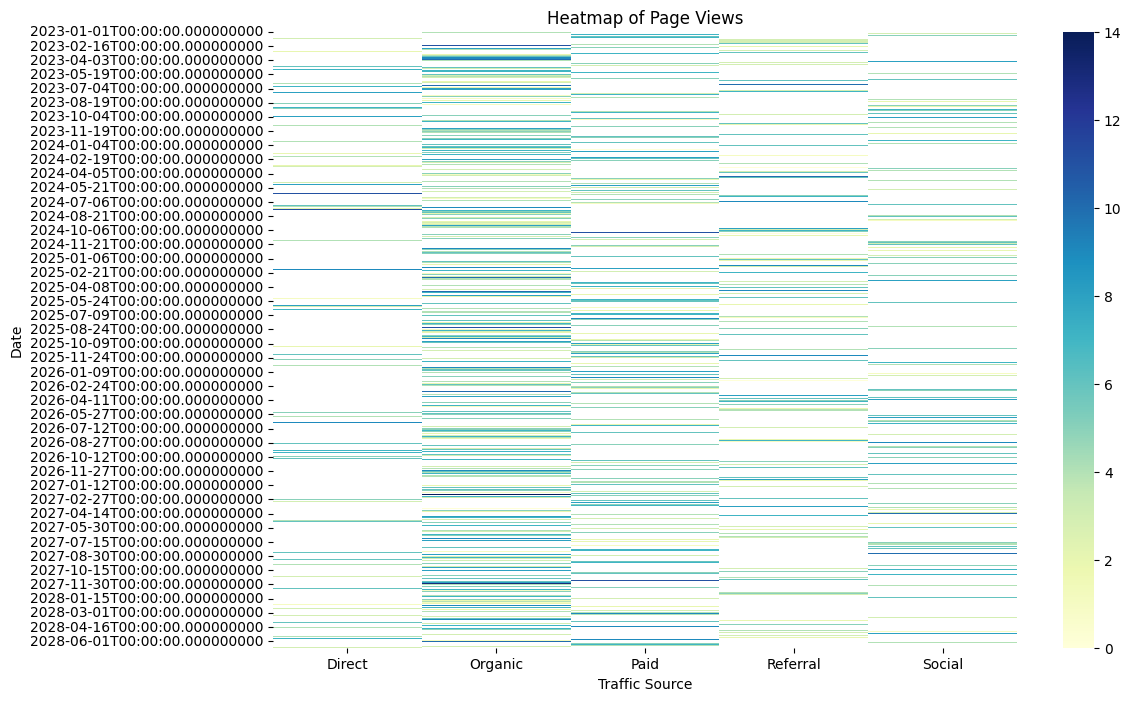

In [33]:
#heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.pivot_table(values='Page Views', index='Date', columns=cat_col), cmap='YlGnBu')
plt.title('Heatmap of Page Views')
plt.show()


MODEL

In [34]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [35]:
# One-hot encode the categorical variable 'Traffic Source'
df= pd.get_dummies(df, columns=['Traffic Source'])

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [36]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(scaled_data, test_size=0.2, random_state=42)

In [37]:
#sequences of LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 3
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [38]:
#build the model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, X_train.shape[2])))
model.add(Dense(X_train.shape[2]))
#optimizer and loss definition
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 13)                  │             663 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,463 (52.59 KB)

 Trainable params: 13,463 (52.59 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from tensorflow import keras
#Define the callback to save the best model during the training
mc = ModelCheckpoint('best_model.keras', monitor='val_loss',verbose=1, save_best_only=True, mode='min')

In [41]:
#train model
history = model.fit(X_train, y_train, epochs=200, verbose=1,validation_data=(X_test, y_test),callbacks=[mc])

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1817
Epoch 1: val_loss improved from inf to 0.08340, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.1808 - val_loss: 0.0834
Epoch 2/200
44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0826
Epoch 2: val_loss improved from 0.08340 to 0.08175, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0826 - val_loss: 0.0818
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0819
Epoch 3: val_loss improved from 0.08175 to 0.08134, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0819 - val_loss: 0.0813
Epoch 4/200
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0812
Epoch 4: val_loss improved from 0.08134 to 0.08128, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0812 - val_loss: 0.0813
Epoch 5/200
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0811
Epoch 5: val_loss improved from 0.08128 

In [42]:
# Making predictions using the trained model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transforming the predictions to original scale
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [43]:
model.load_weights('best_model.keras')

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Inverse transforming the true values to original scale
y_train_true = scaler.inverse_transform(y_train)
y_test_true = scaler.inverse_transform(y_test)

#  Mean Absolute Error
mae_train = mean_absolute_error(y_train_true, train_predictions)
mae_test = mean_absolute_error(y_test_true, test_predictions)

#  Mean Squared Error
mse_train = mean_squared_error(y_train_true, train_predictions)
mse_test = mean_squared_error(y_test_true, test_predictions)

#  Root Mean Squared Error
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print(f'Training MAE: {mae_train:.4f}')
print(f'Testing MAE: {mae_test:.4f}')
print(f'Training MSE: {mse_train:.4f}')
print(f'Testing MSE: {mse_test:.4f}')
print(f'Training RMSE: {rmse_train:.4f}')
print(f'Testing RMSE: {rmse_test:.4f}')

Training MAE: 0.7033
Testing MAE: 0.8347
Training MSE: 1.8171
Testing MSE: 2.3591
Training RMSE: 1.3480
Testing RMSE: 1.5359


Training MAE vs Testing MAE values are relatively close which indicates that this LSTM model is generalizing well to unseen data. Also minimal overfitting.
The small gap between training MSE vs Testing MSE values reveals there are no extreme outliers causing prediction errors in the model.
On the same validation data, I got a score of 2.3424 which is way higher than this previous error.So the LSTM based model has done exceptionally well as compared to the baseline model
These metrics show that the LSTM model is effective in capturing the underlying patterns in the training data and extending that learning to the testing data.

In [45]:
#a simple moving average
def compute_moving_average(data):
    pred = []
    for column in data.select_dtypes(include=np.number): # Select only numerical columns
        avg = np.sum(data[column]) / len(data[column]) # Calculate average for the column
        pred.append(avg)
    return np.array(pred)

# Compute MA for numerical columns only
moving_average = compute_moving_average(df)
print("Moving Average:", moving_average)

Moving Average: [4.9505     3.02204476 0.2847666  4.02743904 1.9785     0.98206529
 1.70724073 1.5       ]


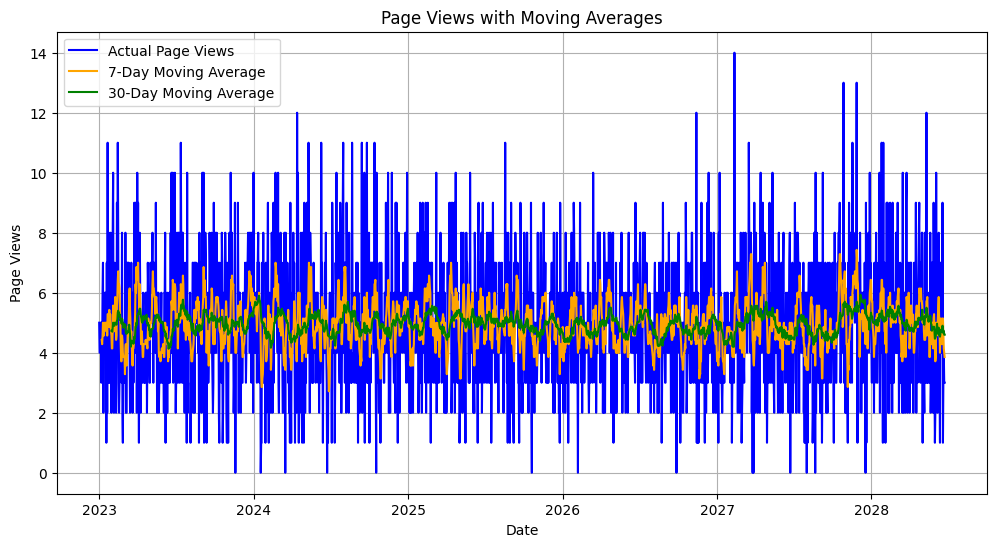

In [46]:
df['7-Day MA'] = df['Page Views'].rolling(window=7).mean()  # 7-day moving average
df['30-Day MA'] = df['Page Views'].rolling(window=30).mean()  # 30-day moving average

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Page Views'], label='Actual Page Views', color='blue')
plt.plot(df.index, df['7-Day MA'], label='7-Day Moving Average', color='orange')
plt.plot(df.index, df['30-Day MA'], label='30-Day Moving Average', color='green')
plt.title('Page Views with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Page Views')
plt.legend()
plt.grid(True)
plt.show()


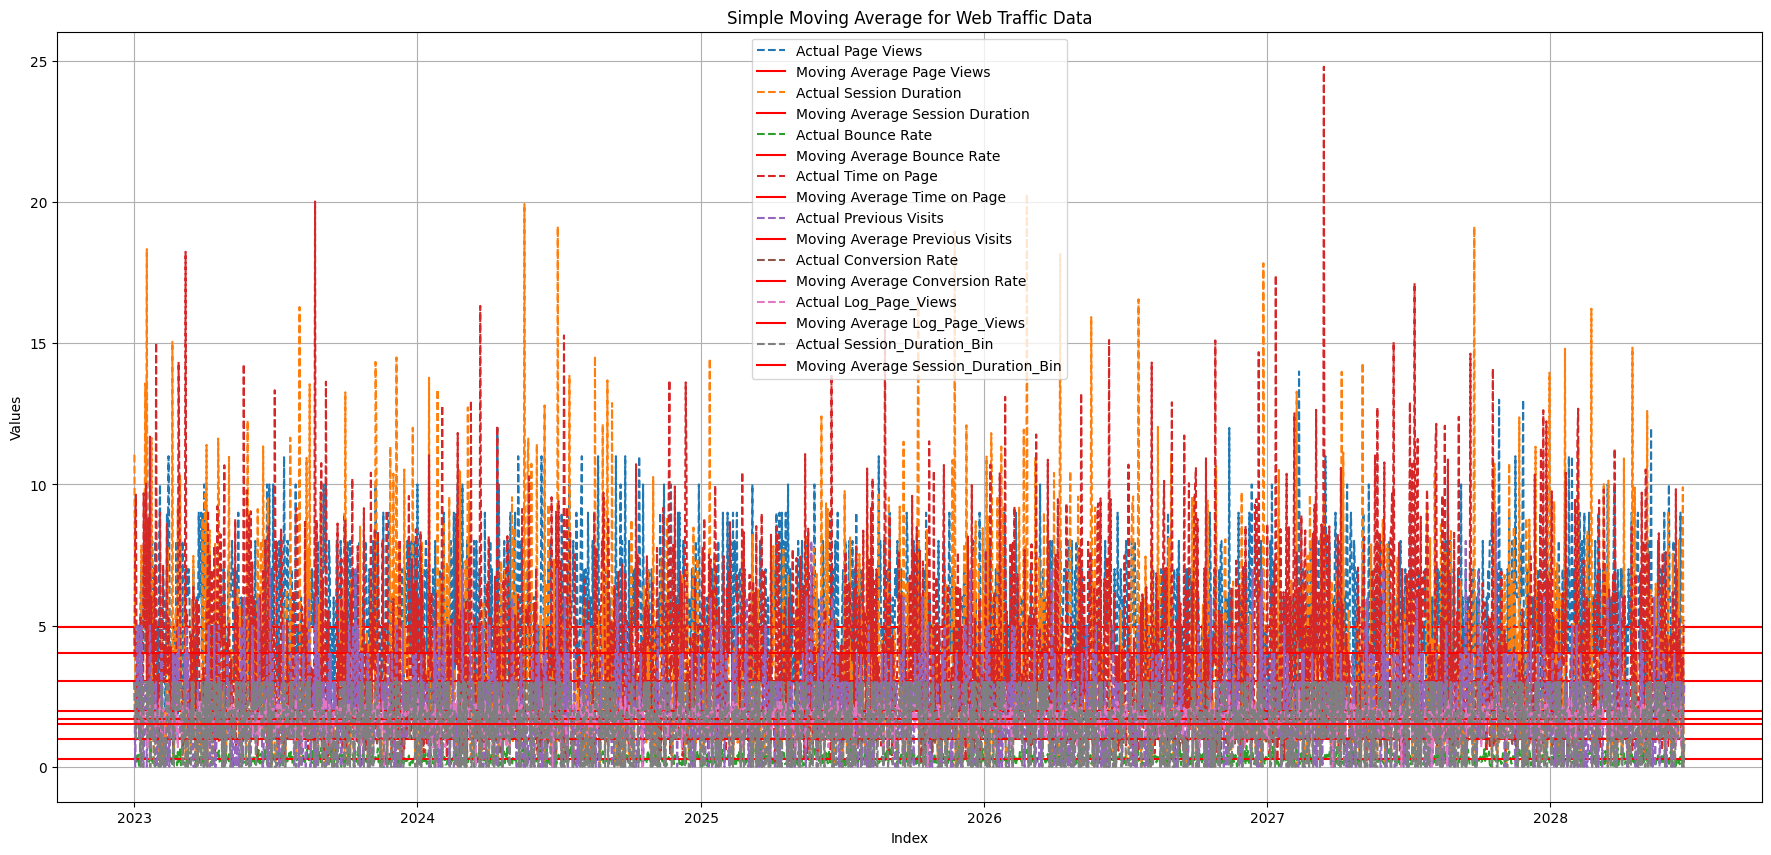

In [48]:
#Plotting the moving average for each column
plt.figure(figsize=(22, 10))

# Define numerical_columns - use the original columns used for calculating moving average
numerical_columns = df.select_dtypes(include=np.number).columns[:len(moving_average)] #select the columns used for ma

for i, col in enumerate(numerical_columns):
    plt.plot(df[col], label=f'Actual {col}', linestyle='--')
    plt.axhline(y=moving_average[i], color='r', linestyle='-', label=f'Moving Average {col}')

plt.title('Simple Moving Average for Web Traffic Data')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Forecasting future steps
def forecast_future(data, model, steps, seq_length):
    current_seq = data[-seq_length:]
    future_predictions = []
    for _ in range(steps):
        next_pred = model.predict(current_seq[np.newaxis, :, :])[0]
        future_predictions.append(next_pred)
        current_seq = np.vstack((current_seq[1:], next_pred))
    return np.array(future_predictions)

# Number of future steps to forecast
future_steps = 24
future_predictions = forecast_future(scaled_data, model, future_steps, seq_length)

# Inverse transform the predictions to original scale
future_predictions = scaler.inverse_transform(future_predictions)

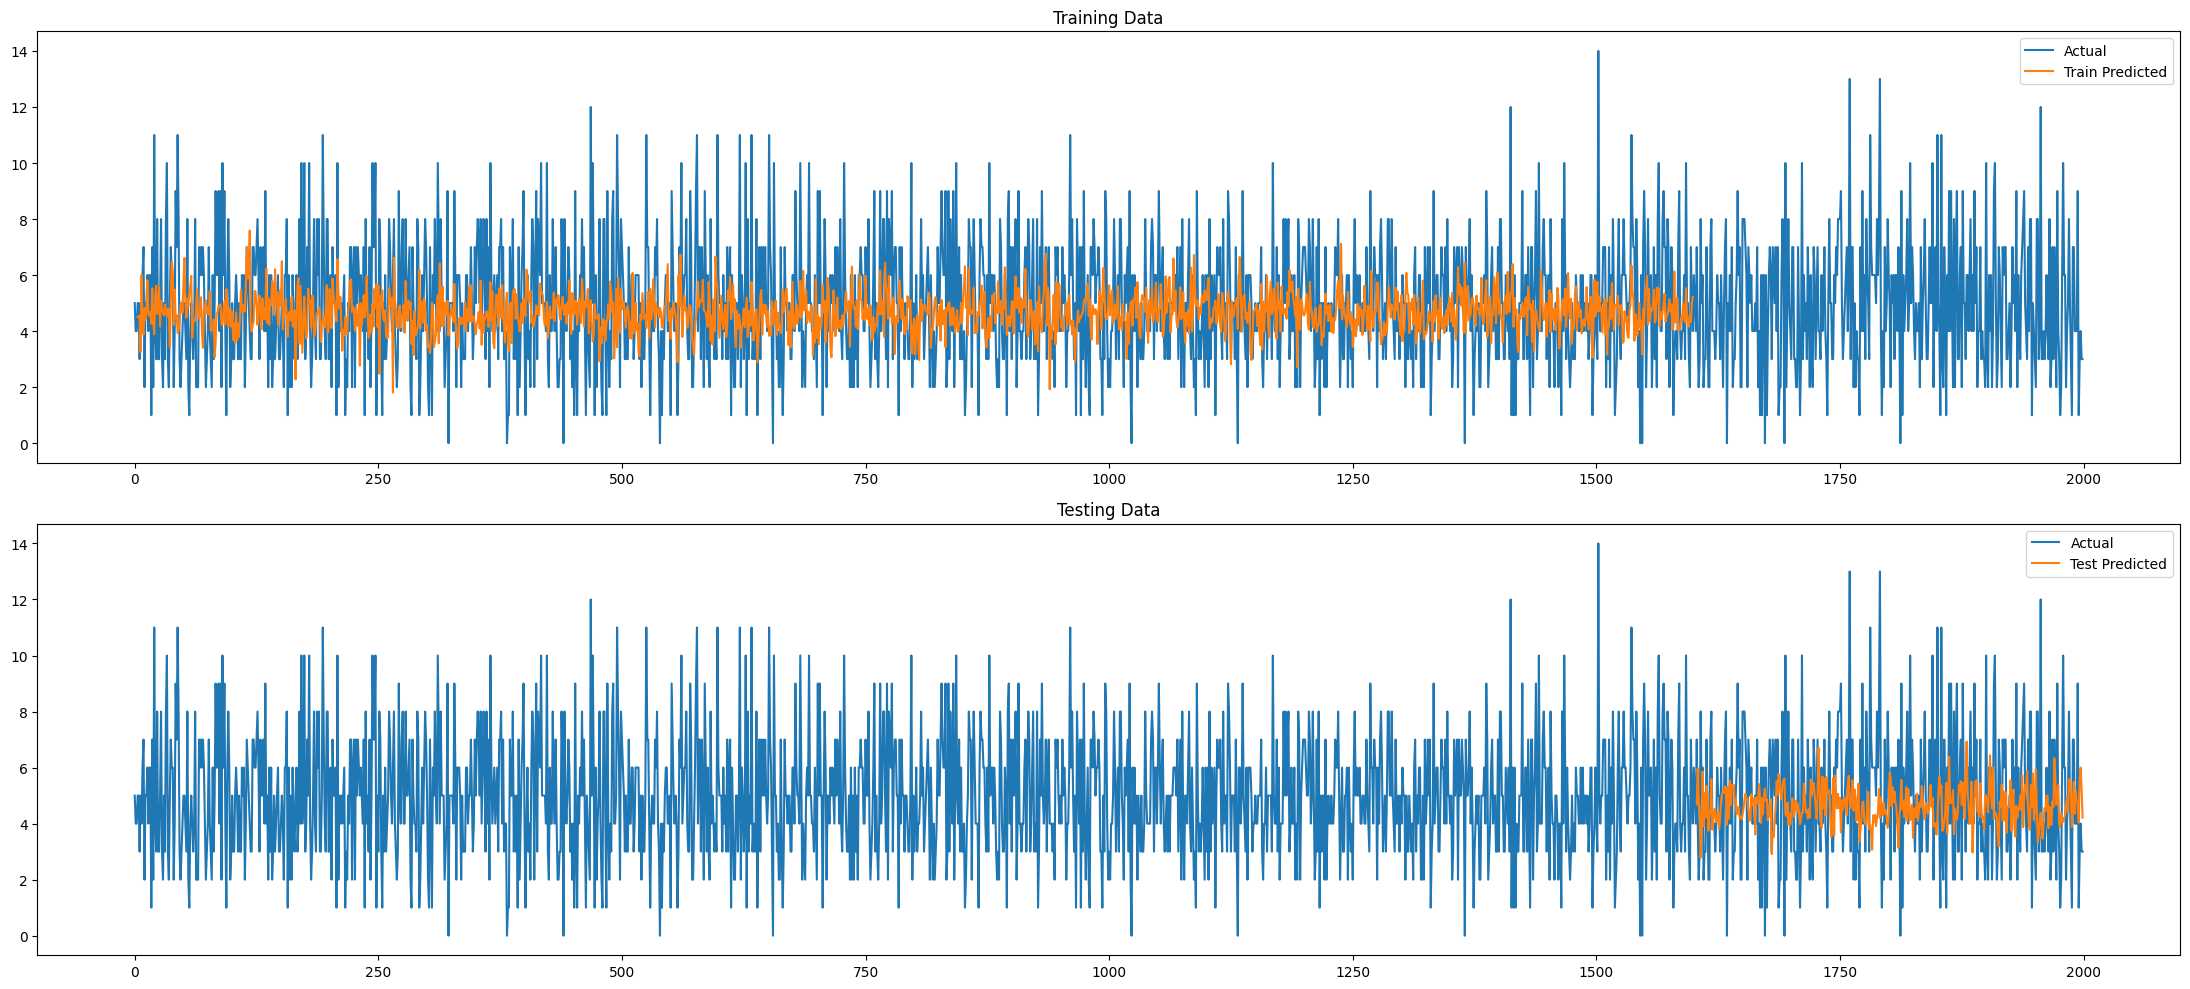

In [49]:
#results visualization
plt.figure(figsize=(22,10))

# Plot for training data
plt.subplot(2, 1, 1)
plt.plot(range(len(df)), df['Page Views'], label='Actual')
plt.plot(range(seq_length, seq_length + len(train_predictions)), train_predictions[:, 0], label='Train Predicted')
plt.title('Training Data')
plt.legend()

# Plot for testing data
plt.subplot(2, 1, 2)
plt.plot(range(len(df)), df['Page Views'], label='Actual')
plt.plot(range(len(df) - len(test_predictions), len(df)), test_predictions[:, 0], label='Test Predicted')
plt.title('Testing Data')
plt.legend()

plt.tight_layout()
plt.show()


In [51]:
import pickle

In [52]:
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved successfully as 'model.pkl'")

Model saved successfully as 'model.pkl'
